In [2]:
#Import pythons libraries and packages to assit with the regression
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt


Read and Clean Data

In [3]:
#import and read the file 
data_path = 'Housing_Prices_24.csv'
house_dat = pd.read_csv(data_path)

# preview data
house_dat.head
print(house_dat)

# drop non-numeric columns
house_dat_num = house_dat.drop(columns=['LotConfig', 'BldgType', 'Foundation', 'CentralAir', 'KitchenQual','PavedDrive'])

        Id  SalePrice  LotArea  TotalBsmtSF  1stFlrSF  2ndFlrSF  FullBath  \
0        1     208500     8450          856       856       854         2   
1        2     181500     9600         1262      1262         0         2   
2        3     223500    11250          920       920       866         2   
3        4     140000     9550          756       961       756         1   
4        5     250000    14260         1145      1145      1053         2   
...    ...        ...      ...          ...       ...       ...       ...   
1455  1456     175000     7917          953       953       694         2   
1456  1457     210000    13175         1542      2073         0         2   
1457  1458     266500     9042         1152      1188      1152         2   
1458  1459     142125     9717         1078      1078         0         1   
1459  1460     147500     9937         1256      1256         0         1   

      HalfBath  BedroomAbvGr  TotRmsAbvGrd  ...  PoolArea  LotConfig  \
0  

Explore Data (correlations, scatterplots)

                Id      SalePrice        LotArea  TotalBsmtSF     1stFlrSF  \
count  1460.000000    1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000  180921.195890   10516.828082  1057.429452  1162.626712   
std     421.610009   79442.502883    9981.264932   438.705324   386.587738   
min       1.000000   34900.000000    1300.000000     0.000000   334.000000   
25%     365.750000  129975.000000    7553.500000   795.750000   882.000000   
50%     730.500000  163000.000000    9478.500000   991.500000  1087.000000   
75%    1095.250000  214000.000000   11601.500000  1298.250000  1391.250000   
max    1460.000000  755000.000000  215245.000000  6110.000000  4692.000000   

          2ndFlrSF     FullBath     HalfBath  BedroomAbvGr  TotRmsAbvGrd  ...  \
count  1460.000000  1460.000000  1460.000000   1460.000000   1460.000000  ...   
mean    346.992466     1.565068     0.382877      2.866438      6.517808  ...   
std     436.528436     0.550916     0.502885      0.81

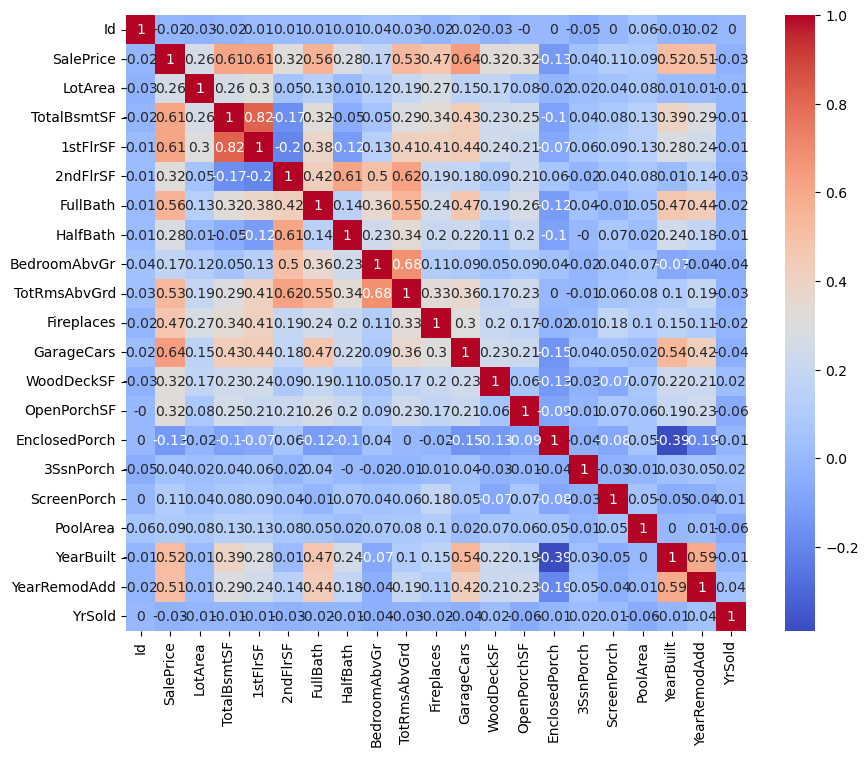

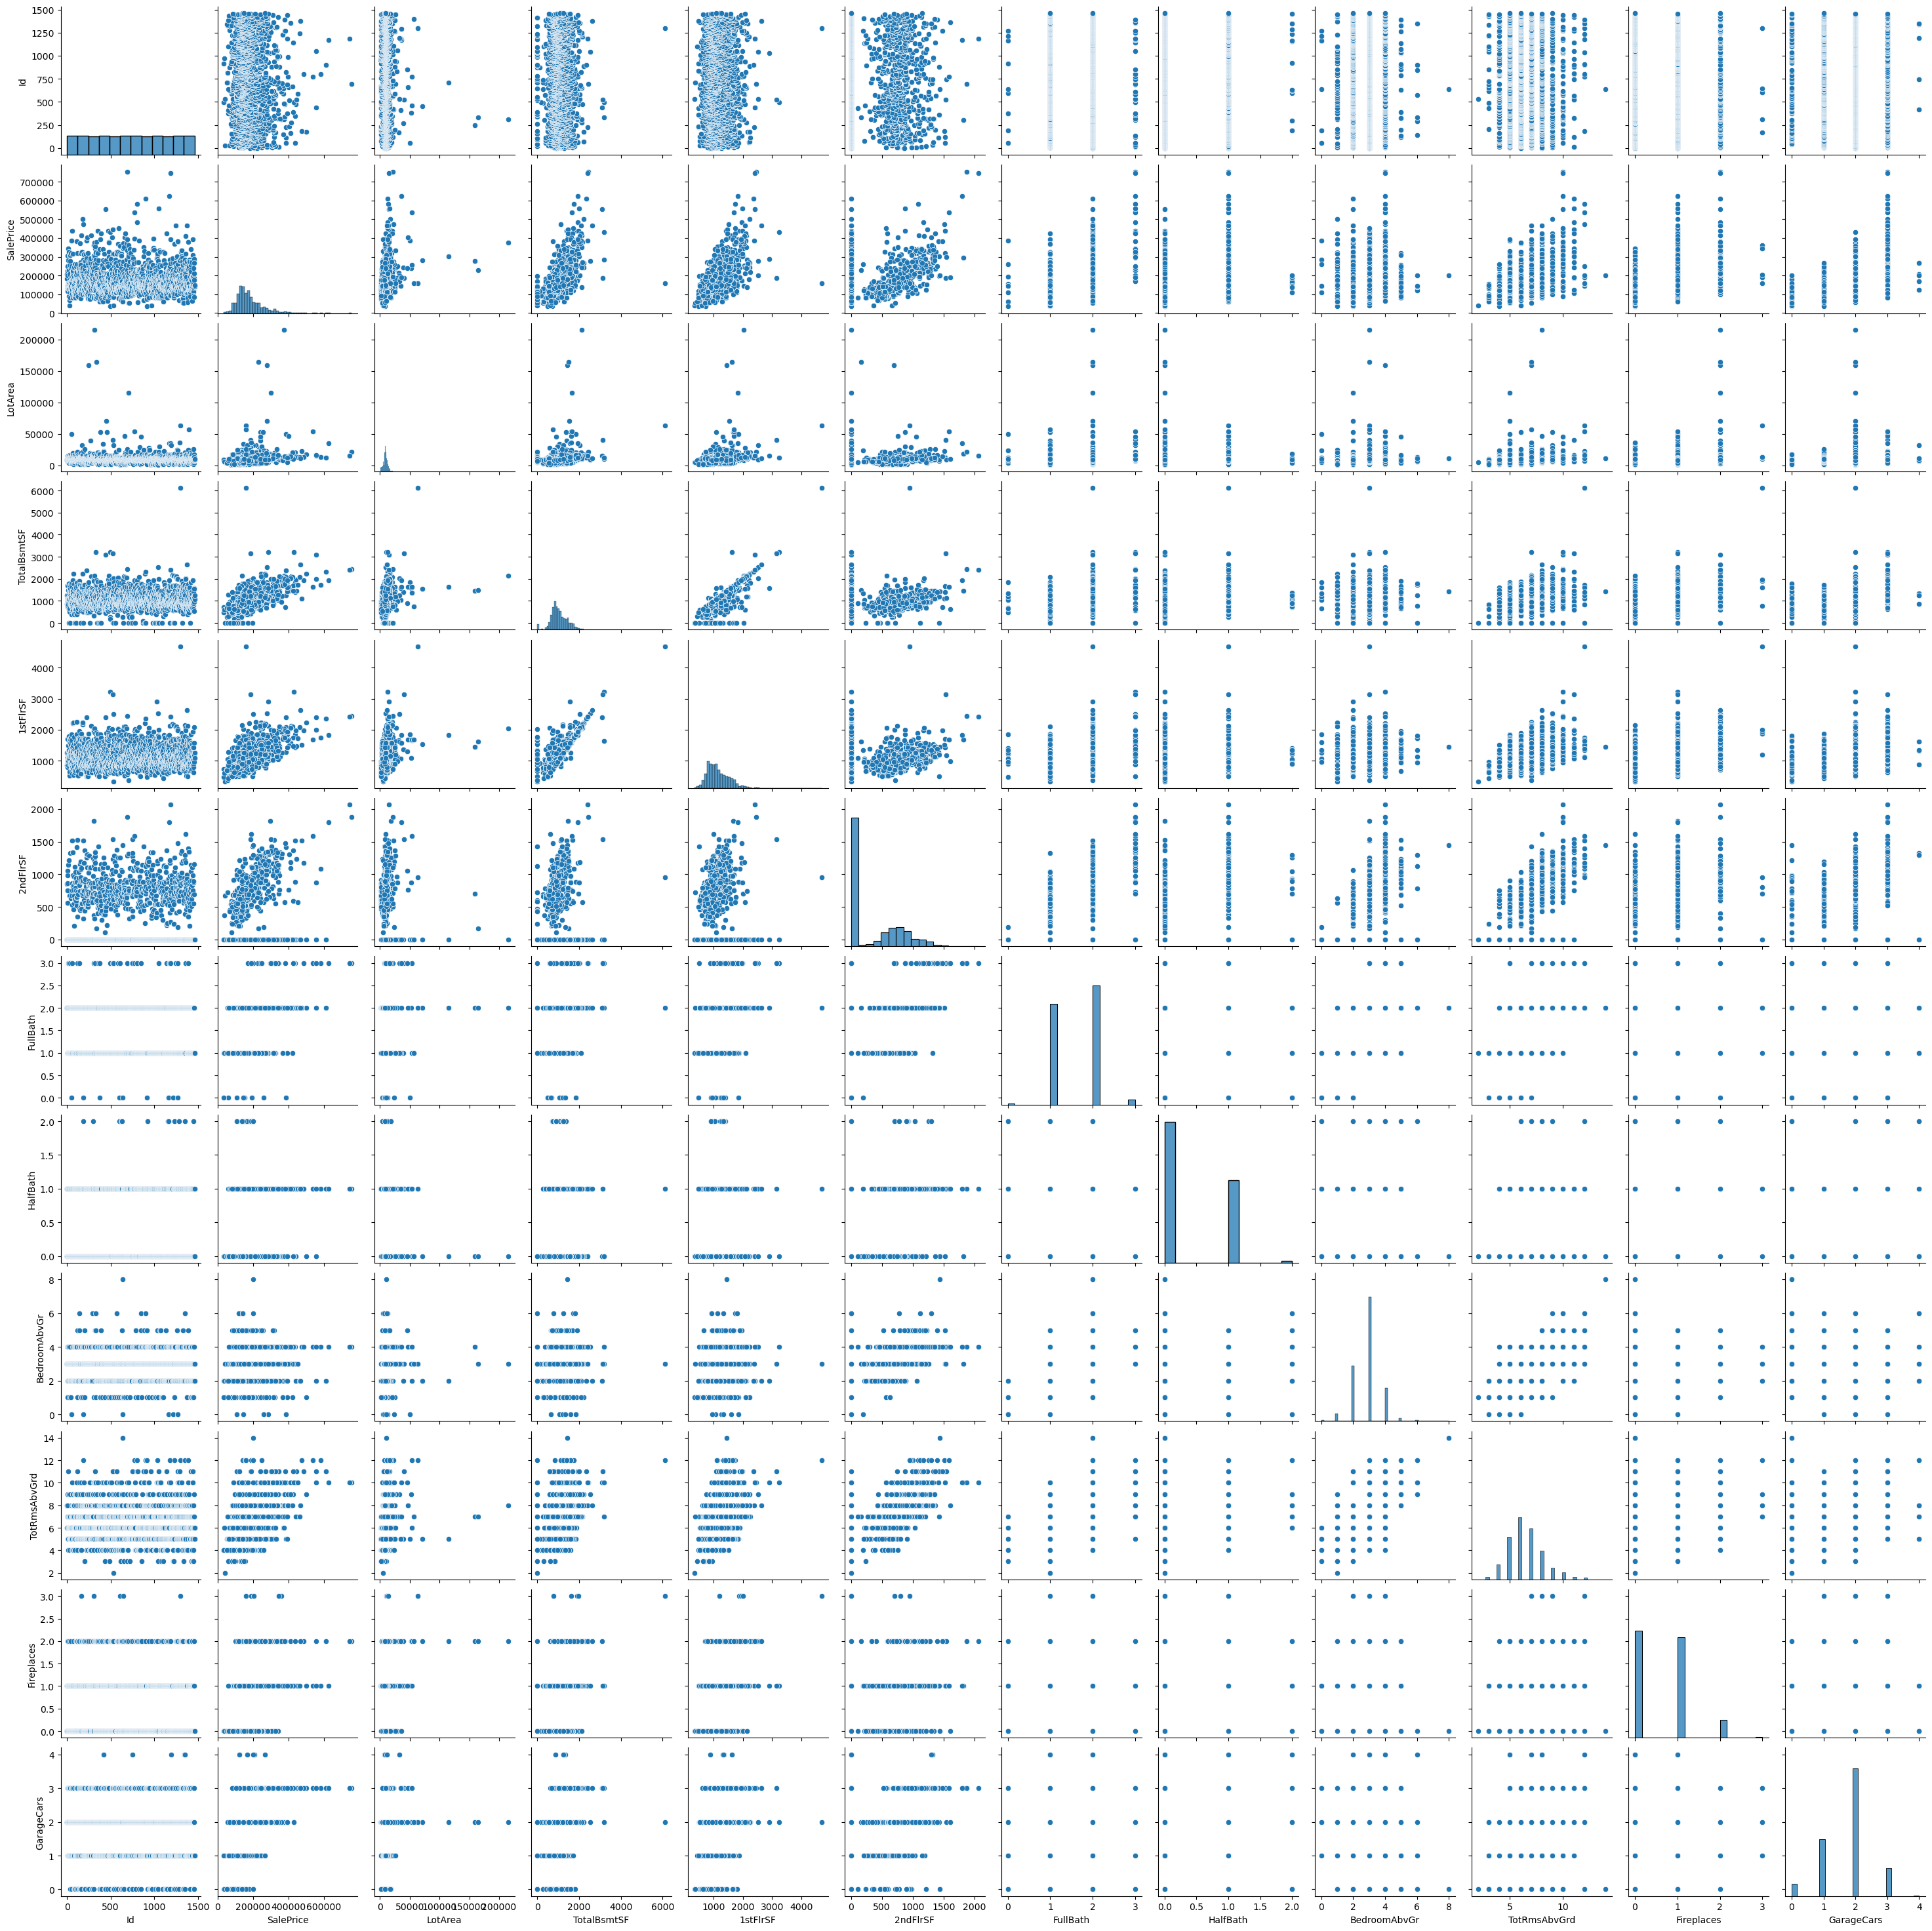

In [4]:
# Display summary statistics for numeric variables
print(house_dat_num.describe())

# Compute correlations
cormat = house_dat_num.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

# Create scatterplot matrix
sns.pairplot(house_dat_num.iloc[:,:12])
plt.show()

Fit the Full Regression Model Using Only the Numeric Explanatory Variables

In [5]:
# Fit full regression
X = house_dat_num.drop(columns=['SalePrice'])
y = house_dat['SalePrice']
X = sm.add_constant(X)
fullreg = sm.OLS(y, X).fit()

# Display regression summary
print(fullreg.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     222.1
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:40:41   Log-Likelihood:                -17516.
No. Observations:                1460   AIC:                         3.507e+04
Df Residuals:                    1439   BIC:                         3.519e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.716e+05   1.58e+06     -0.488

Calculate Variance Inflation Factors (VIF) for full model

In [6]:
#Calculate Variance Inflation Factors (VIF) for full model
vifres = pd.DataFrame()
vifres["Variable"] = X.columns
vifres["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifres)


         Variable           VIF
0           const  2.327048e+06
1              Id  1.013572e+00
2         LotArea  1.172562e+00
3     TotalBsmtSF  3.482324e+00
4        1stFlrSF  5.597009e+00
5        2ndFlrSF  4.832845e+00
6        FullBath  2.639452e+00
7        HalfBath  2.136282e+00
8    BedroomAbvGr  2.130529e+00
9    TotRmsAbvGrd  4.352000e+00
10     Fireplaces  1.456012e+00
11     GarageCars  1.856250e+00
12     WoodDeckSF  1.170610e+00
13    OpenPorchSF  1.191487e+00
14  EnclosedPorch  1.241887e+00
15      3SsnPorch  1.016901e+00
16    ScreenPorch  1.093724e+00
17       PoolArea  1.066410e+00
18      YearBuilt  2.865800e+00
19   YearRemodAdd  1.740687e+00
20         YrSold  1.015357e+00


Create function for automated Forward / Backward model selection

In [7]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


Automated Variable Selection

In [8]:
selected_features  = stepwise_selection(X, y)
print('resulting features:')
print(selected_features)

Add  const with p-value 0.0000
Add  GarageCars with p-value 0.0000
Add  TotalBsmtSF with p-value 0.0000
Add  2ndFlrSF with p-value 0.0000
Add  YearRemodAdd with p-value 0.0000
Add  1stFlrSF with p-value 0.0000
Add  YearBuilt with p-value 0.0000
Add  Fireplaces with p-value 0.0000
Add  BedroomAbvGr with p-value 0.0000
Add  WoodDeckSF with p-value 0.0004
Add  ScreenPorch with p-value 0.0009
Add  TotRmsAbvGrd with p-value 0.0014
Add  LotArea with p-value 0.0011
resulting features:
['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'TotRmsAbvGrd', 'LotArea']


In [9]:
# Fit stepwise regression
X = house_dat_num[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'TotRmsAbvGrd', 'LotArea']]
X = sm.add_constant(X)
stepreg = sm.OLS(y, X).fit()

# Display regression summary
print(stepreg.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     369.2
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:40:41   Log-Likelihood:                -17521.
No. Observations:                1460   AIC:                         3.507e+04
Df Residuals:                    1447   BIC:                         3.514e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.811e+06    1.2e+05    -15.130   

In [10]:
vifresstep = pd.DataFrame()
vifresstep["Variable"] = X.columns
vifresstep["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresstep)


        Variable           VIF
0          const  13353.593970
1     GarageCars      1.835400
2    TotalBsmtSF      3.390095
3       2ndFlrSF      3.153687
4   YearRemodAdd      1.685953
5       1stFlrSF      5.147880
6      YearBuilt      2.016720
7     Fireplaces      1.439849
8   BedroomAbvGr      2.092256
9     WoodDeckSF      1.148369
10   ScreenPorch      1.062585
11  TotRmsAbvGrd      4.283360
12       LotArea      1.168127


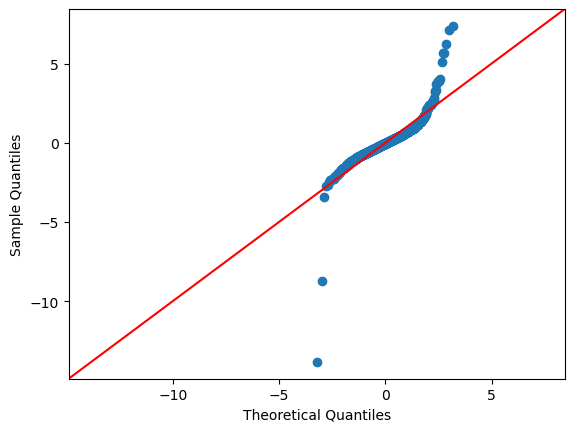

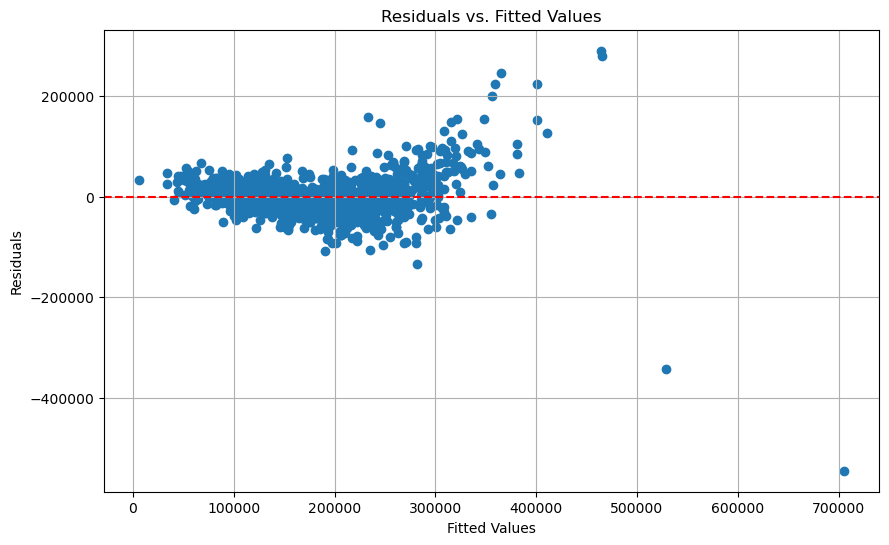

In [11]:
# Calculate residuals
residuals = stepreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals,fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(stepreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Try a log transformation and a square root transformation and compare the results

In [12]:
# log transformed regression
X = house_dat_num[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'TotRmsAbvGrd', 'LotArea']]
X = sm.add_constant(X)
logy = np.log(y)
logreg = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     497.5
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:40:42   Log-Likelihood:                 461.69
No. Observations:                1460   AIC:                            -897.4
Df Residuals:                    1447   BIC:                            -828.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3371      0.536     -2.496   

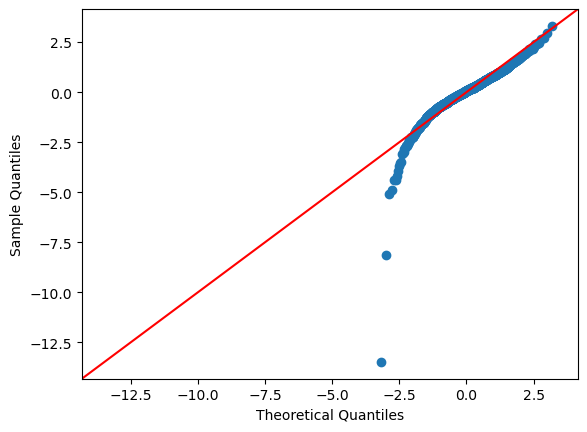

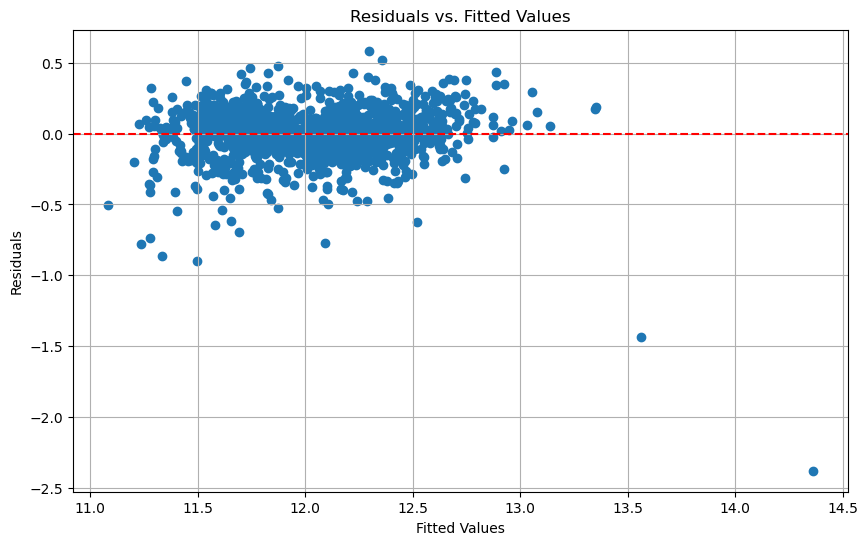

In [13]:
# Calculate residuals
residuals = logreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [14]:
# Square Root transformed regression
X = house_dat_num[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'YearBuilt', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'TotRmsAbvGrd', 'LotArea']]
X = sm.add_constant(X)
sqrty = np.sqrt(y)
sqrtreg = sm.OLS(sqrty, X).fit()

# Display regression summary
print(sqrtreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     481.7
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:40:42   Log-Likelihood:                -7396.5
No. Observations:                1460   AIC:                         1.482e+04
Df Residuals:                    1447   BIC:                         1.489e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2142.6890    116.548    -18.385   

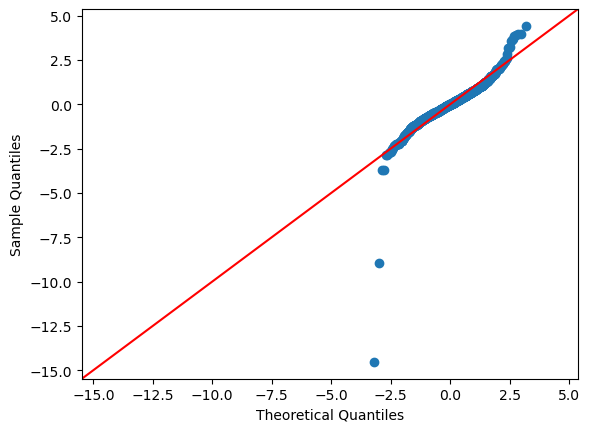

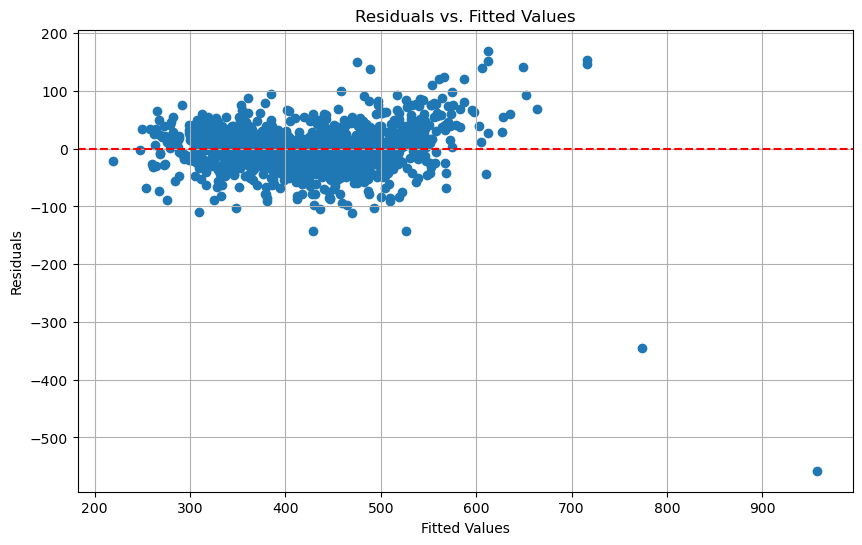

In [15]:
# Calculate residuals
residuals = sqrtreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(sqrtreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Examine the relationships between Make and Type of the car and price using boxplots

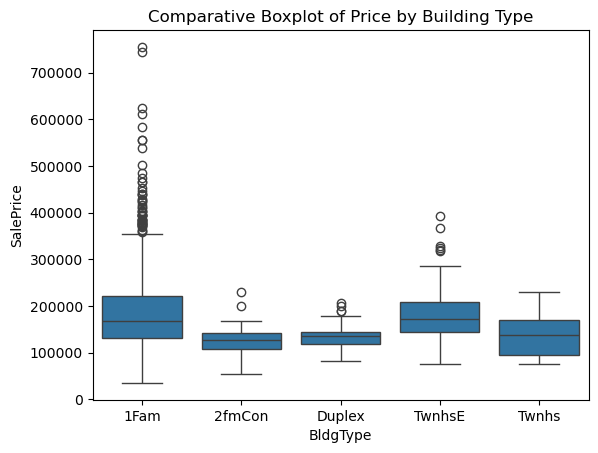

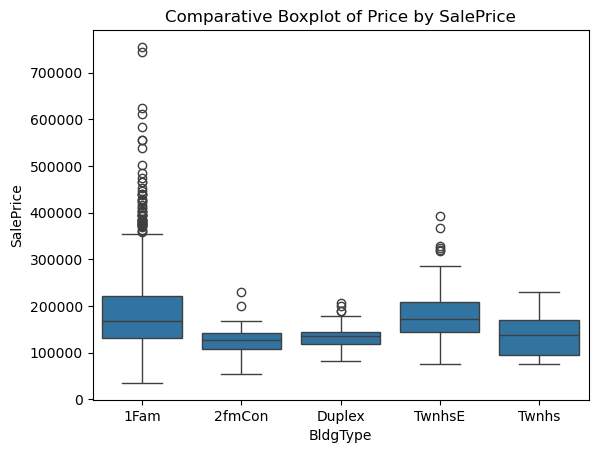

In [16]:
#Look at Building type vs Price
sns.boxplot(x="BldgType", y="SalePrice", data=house_dat)

# Add labels and a title
plt.xlabel("BldgType")
plt.ylabel("SalePrice")
plt.title("Comparative Boxplot of Price by Building Type")

# Show the plot
plt.show()

#Look at Type vs Price
sns.boxplot(x="BldgType", y="SalePrice", data=house_dat)

# Add labels and a title
plt.xlabel("BldgType")
plt.ylabel("SalePrice")
plt.title("Comparative Boxplot of Price by SalePrice")

# Show the plot
plt.show()



In [17]:
print(house_dat)

        Id  SalePrice  LotArea  TotalBsmtSF  1stFlrSF  2ndFlrSF  FullBath  \
0        1     208500     8450          856       856       854         2   
1        2     181500     9600         1262      1262         0         2   
2        3     223500    11250          920       920       866         2   
3        4     140000     9550          756       961       756         1   
4        5     250000    14260         1145      1145      1053         2   
...    ...        ...      ...          ...       ...       ...       ...   
1455  1456     175000     7917          953       953       694         2   
1456  1457     210000    13175         1542      2073         0         2   
1457  1458     266500     9042         1152      1188      1152         2   
1458  1459     142125     9717         1078      1078         0         1   
1459  1460     147500     9937         1256      1256         0         1   

      HalfBath  BedroomAbvGr  TotRmsAbvGrd  ...  PoolArea  LotConfig  \
0  

In [18]:
# log transformed regression including categorical variables
X = house_dat[['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','YearBuilt','YearRemodAdd','YrSold','LotConfig', 'BldgType','Foundation','CentralAir','KitchenQual','PavedDrive']]
X = pd.get_dummies(X, columns=['LotConfig', 'BldgType','Foundation','CentralAir','KitchenQual','PavedDrive'], drop_first=True, dtype='float')
X = sm.add_constant(X)
logy = np.log(y)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     191.3
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:40:42   Log-Likelihood:                 590.47
No. Observations:                1460   AIC:                            -1103.
Df Residuals:                    1421   BIC:                            -896.8
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                14.6651      6.58

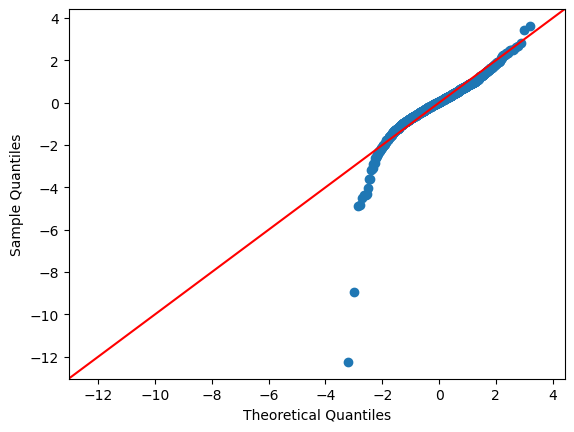

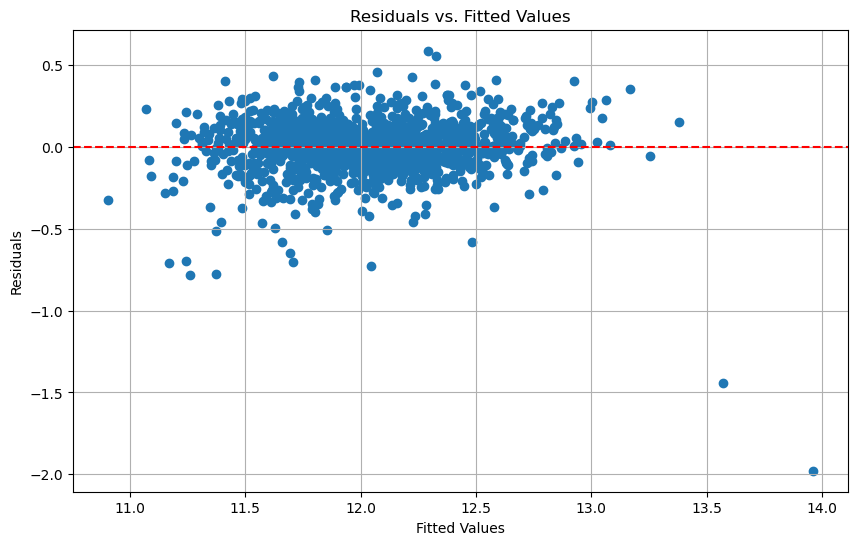

In [19]:
# Calculate residuals
residuals = logreg2.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg2.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

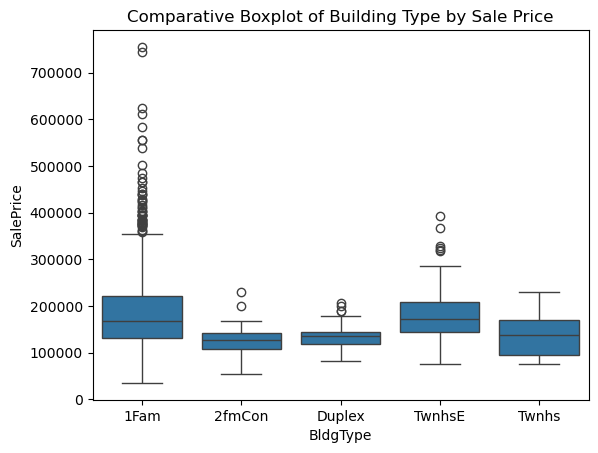

In [20]:
#Look at Make vs Price
sns.boxplot(x="BldgType", y="SalePrice", data=house_dat)

# Add labels and a title
plt.xlabel("BldgType")
plt.ylabel("SalePrice")
plt.title("Comparative Boxplot of Building Type by Sale Price")

# Show the plot
plt.show()


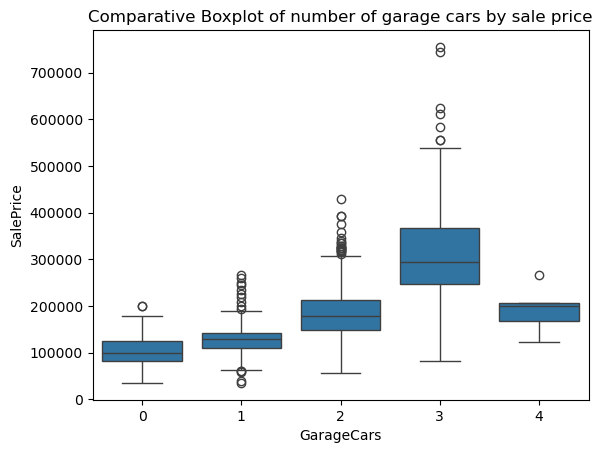

In [21]:
#Look at Type vs Price
sns.boxplot(x="GarageCars", y="SalePrice", data=house_dat)

# Add labels and a title
plt.xlabel("GarageCars")
plt.ylabel("SalePrice")
plt.title("Comparative Boxplot of number of garage cars by sale price")

# Show the plot
plt.show()


In [22]:

X = house_dat[['LotArea','TotalBsmtSF', 'GarageCars','1stFlrSF', '2ndFlrSF','BldgType', 'YearRemodAdd', 'YearBuilt','TotRmsAbvGrd','Fireplaces','WoodDeckSF', 'ScreenPorch','CentralAir','KitchenQual', 'PavedDrive']]
X = pd.get_dummies(X, columns=['BldgType', 'CentralAir','KitchenQual','PavedDrive'], drop_first=True, dtype='float')
X = sm.add_constant(X)
logy = np.log(y)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     334.7
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:40:43   Log-Likelihood:                 562.77
No. Observations:                1460   AIC:                            -1082.
Df Residuals:                    1438   BIC:                            -965.3
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9495      0.628     

Use two simple models to explore the effect of interaction terms on the model

Use two simple models to explore the effect of interaction terms on the model

In [23]:
#import and read the file 
data_path = 'homesforsale.csv'
house_11_dat = pd.read_csv(data_path)


Xnu = house_11_dat[['LotArea','TotalBsmtSF', 'GarageCars','1stFlrSF', '2ndFlrSF','BldgType', 'YearRemodAdd', 'YearBuilt','TotRmsAbvGrd','Fireplaces','WoodDeckSF', 'ScreenPorch','CentralAir','KitchenQual', 'PavedDrive']]
Xnu = pd.get_dummies(Xnu, columns=['BldgType', 'CentralAir','KitchenQual','PavedDrive'], drop_first=True, dtype='float')
Xnu = sm.add_constant(Xnu)
Xnu['BldgType_2fmCon'] = 0  
Xnu['BldgType_Twnhs'] = 0
Xnu['BldgType_TwnhsE'] = 0
Xnu['CentralAir_Y'] = 0
Xnu['PavedDrive_Y'] = 0
Xnu['PavedDrive_P'] = 0


In [24]:
predictions = logreg2.predict(Xnu)
new_dat =np.exp(predictions)

In [25]:
print(new_dat)

0    152253.360902
1    159127.436640
2    172281.325856
3    299082.500759
4    120601.182843
dtype: float64


In [26]:
X.dtypes


const              float64
LotArea              int64
TotalBsmtSF          int64
GarageCars           int64
1stFlrSF             int64
2ndFlrSF             int64
YearRemodAdd         int64
YearBuilt            int64
TotRmsAbvGrd         int64
Fireplaces           int64
WoodDeckSF           int64
ScreenPorch          int64
BldgType_2fmCon    float64
BldgType_Duplex    float64
BldgType_Twnhs     float64
BldgType_TwnhsE    float64
CentralAir_Y       float64
KitchenQual_Fa     float64
KitchenQual_Gd     float64
KitchenQual_TA     float64
PavedDrive_P       float64
PavedDrive_Y       float64
dtype: object

In [27]:
Xnu.dtypes

const              float64
LotArea              int64
TotalBsmtSF          int64
GarageCars           int64
1stFlrSF             int64
2ndFlrSF             int64
YearRemodAdd         int64
YearBuilt            int64
TotRmsAbvGrd         int64
Fireplaces           int64
WoodDeckSF           int64
ScreenPorch          int64
BldgType_Duplex    float64
KitchenQual_Fa     float64
KitchenQual_Gd     float64
KitchenQual_TA     float64
BldgType_2fmCon      int64
BldgType_Twnhs       int64
BldgType_TwnhsE      int64
CentralAir_Y         int64
PavedDrive_Y         int64
PavedDrive_P         int64
dtype: object